In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, ExpectileGAM

In [2]:
def read_energy(fn):
    with open(fn) as fh:
        lines = fh.readlines()
    lines = [_ for _ in lines if 'HF/cc-pVDZ energy' in _]
    return float(lines[0].strip().split()[-1])
def parse_meta(fn):
    fn = fn.split('/')[-1]
    parts = fn.split('.')[0].split('-')
    return {'group': int(parts[0]), 'frame': int(parts[1])}
def parse_meta(fn):
    fn = fn.split('/')[-1]
    parts = fn.split('.')[0].split('-')
    return {'frame': int(parts[1])}

In [72]:
res = []
for fn in glob.glob('build_colored_graphs/db-12/done/debug/*.out'):
    this = parse_meta(fn)
    this['energy'] = read_energy(fn)
    res.append(this)
df = pd.DataFrame(res).sort_values('frame'.split()).reset_index(drop=True)

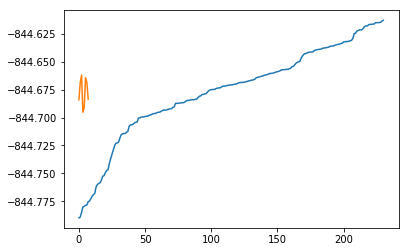

In [17]:
plt.plot(sorted(df.energy.values))
plt.plot(df[df.frame.isin([201,193,51,48,192,47,204,54])].energy.values)

In [94]:
cmp = None

Text(0, 0.5, 'Estimated rank')

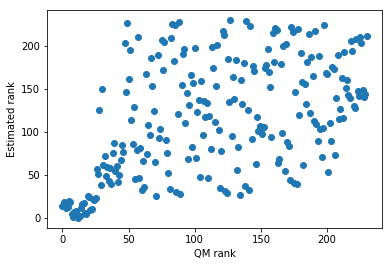

In [95]:
ranking = np.fromfile('build_colored_graphs/db-12/done/ranking', dtype=np.int32)
#cmp = np.loadtxt('build_colored_graphs/db-12/ranking.txt')
molecules = ['M%d' % _ for _ in range(231)]
QMorder = ['M%d' % _ for _ in np.argsort(df.energy.values)]
APorder = ['M%d' % _ for _ in ranking]
QMrank = [QMorder.index(_) for _ in molecules]
APrank = [APorder.index(_) for _ in molecules]
plt.scatter(QMrank, APrank)
plt.xlabel('QM rank')
plt.ylabel('Estimated rank')

[  3  13  23  33  43  53  63  73  83  93 103 113 123 133 143 153 163 173
 183 193 203 213 223]


Text(0, 0.5, 'QM energy difference [mHa]')

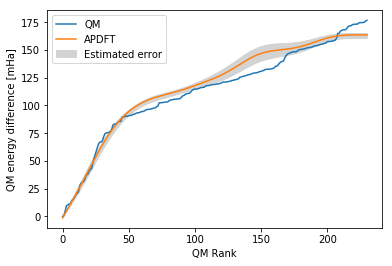

In [318]:
vals = np.array(sorted(df.energy.values))
shift = min(vals)
plt.plot((vals-shift)*1000, label='QM')
space = 10
margin = 3
nvals = int(230/space)
tested = np.arange(margin, 230, space)

print (tested)
ys = [avglookup(_, margin) for _ in tested]

gam1 = LinearGAM(s(0,  constraints='monotonic_inc')).fit(tested.reshape(-1, 1), ys)
gam50 = ExpectileGAM(s(0,  constraints='monotonic_inc'), expectile=0.5, lam=gam1.lam).fit(tested.reshape(-1, 1), ys)
gam66 = ExpectileGAM(s(0,  constraints='monotonic_inc'), expectile=0.66, lam=gam1.lam).fit(tested.reshape(-1, 1), ys)
gam33 = ExpectileGAM(s(0,  constraints='monotonic_inc'), expectile=0.33, lam=gam1.lam).fit(tested.reshape(-1, 1), ys)
plt.plot(xs, (gam50.predict(xs)-shift)*1000, label='APDFT')
plt.fill_between(xs, (gam66.predict(xs)-shift)*1000, (gam33.predict(xs)-shift)*1000, color='lightgrey', label='Estimated error')
plt.legend()

plt.xlabel('QM Rank')
plt.ylabel('QM energy difference [mHa]')

In [100]:
lookup_keys = ['M%d' % _ for _ in df.frame.values]
lookup_values = df.energy.values
lookup = dict(zip(lookup_keys, lookup_values))

In [304]:
def avglookup(around, margin):
    margin = 2
    start = max(0, around-margin)
    stop = min(230, around+margin)
    energies = np.array([lookup[APorder[_]] for _ in range(start, stop)])
    return np.percentile(energies, around/231.*100)